### Interpretation of the LR models

Here, we compare the coefficients learned by the different linear regression models.

These coefficients can be downloaded from Zenodo.

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

### Read and filter weights

In [3]:
h_glia_all = pd.read_csv('../../Zenodo/Human/HPC/LR_weights/LR_all_glia.csv', index_col=0)
h_neur_all = pd.read_csv('../../Zenodo/Human/HPC/LR_weights/LR_all_neur.csv', index_col=0)

h_glia_var = pd.read_csv('../../Zenodo/Human/HPC/LR_weights/LR_var01_glia.csv', index_col=0)
h_neur_var = pd.read_csv('../../Zenodo/Human/HPC/LR_weights/LR_var01_neur.csv', index_col=0)

f_glia_all = pd.read_csv('../../Zenodo/Human/FC/LR_weights/LR_all_glia.csv', index_col=0)
f_neur_all = pd.read_csv('../../Zenodo/Human/FC/LR_weights/LR_all_neur.csv', index_col=0)

f_glia_var = pd.read_csv('../../Zenodo/Human/FC/LR_weights/LR_var01_glia.csv', index_col=0)
f_neur_var = pd.read_csv('../../Zenodo/Human/FC/LR_weights/LR_var01_neur.csv', index_col=0)

In [6]:
w = pd.concat((h_glia_all, h_neur_all, h_glia_var, h_neur_var, f_glia_all, f_neur_all, f_glia_var, f_neur_var), axis=1)
w.columns = ['HPC - glia (all)', 'HPC - neur (all)', 'HPC - glia (var)', 'HPC - neur (var)',
             'FC - glia (all)', 'FC - neur (all)', 'FC - glia (var)', 'FC - neur (var)']
w.iloc[:5]

,HPC - glia (all),HPC - neur (all),HPC - glia (var),HPC - neur (var),FC - glia (all),FC - neur (all),FC - glia (var),FC - neur (var)
AATF_start,0.001789,0.002657,-0.028788,-0.015118,0.006841,0.011354,0.051733,0.033854
ABCF1_start,-0.008563,-0.001489,-0.058113,0.005881,-0.012368,-0.012356,0.006356,-0.002545
AKAP1_start,0.014131,0.022668,-0.001819,0.004053,0.028713,0.030119,0.041527,0.029148
APOBEC3C_start,0.000020,0.000248,-0.003887,-0.027109,0.004455,-0.002225,0.015817,-0.063274
AQR_start,-0.010190,-0.012180,-0.005953,-0.018397,-0.009925,-0.014481,0.021509,0.005704


Read the RBP counts, so we can use this to filter the RBPs. We will only keep RBPs with at least 50 binding sites. If there are few binding sites, the coefficient of the RBP might not be estimated with enough confidence.

In [12]:
# HPC
PSI_glia = pd.read_csv('../../Zenodo/Human/HPC/PSI/PSI_glia_norm.csv', index_col=0)
PSI_neur = pd.read_csv('../../Zenodo/Human/HPC/PSI/PSI_neur_norm.csv', index_col=0)

# Check which exons are variable
exons_all = PSI_glia['0'].notna() & PSI_neur['0'].notna()
exons_var01 = PSI_glia.index[(np.abs(PSI_glia['0'] - PSI_neur['0']) > 0.1)]

RBP = pd.read_csv('../../Zenodo/Human/HPC/RBP/RBP_peaks.csv', index_col=0)
RBP_hpc_var01 = np.sum(RBP.loc[exons_var01] > 0)
RBP_hpc_all = np.sum(RBP.loc[exons_all] > 0)

In [13]:
# FC
PSI_glia = pd.read_csv('../../Zenodo/Human/FC/PSI/PSI_glia_norm.csv', index_col=0)
PSI_neur = pd.read_csv('../../Zenodo/Human/FC/PSI/PSI_neur_norm.csv', index_col=0)

# Check which exons are variable
exons_all = PSI_glia['0'].notna() & PSI_neur['0'].notna()
exons_var01 = PSI_glia.index[(np.abs(PSI_glia['0'] - PSI_neur['0']) > 0.1)]

RBP = pd.read_csv('../../Zenodo/Human/FC/RBP/RBP_peaks.csv', index_col=0)
exon_RBP = RBP.index
index = pd.DataFrame(exon_RBP)[0].str.split(pat="\.|_", expand=True)
exon_RBP = index[0] + '_' + index[1] + '_' + index[2] + '_' + index[3] + '_' + index[5] 
RBP.index = exon_RBP
RBP_fc_var01 = np.sum(RBP.loc[exons_var01] > 0)
RBP_fc_all = np.sum(RBP.loc[exons_all] > 0)

In [15]:
RBP_counts = pd.concat((RBP_hpc_all, RBP_hpc_var01, RBP_fc_all, RBP_fc_var01), axis=1)
RBP_counts.columns = ['HPC (all)', 'HPC (var)', 'FC (all)', 'FC (var)']
RBP_counts.iloc[:5]

,HPC (all),HPC (var),FC (all),FC (var)
AATF_start,1545,381,1241,234
ABCF1_start,1043,260,689,122
AKAP1_start,3071,766,2283,409
APOBEC3C_start,2358,528,1764,319
AQR_start,11642,2759,7301,1478


In [16]:
print(np.shape(w))

# There should be enough binding sites to estimate a coefficient 
w_filt = w[np.min(RBP_counts.iloc[:,:4], axis=1) >= 50] 
print(np.shape(w_filt))

# There should be at least one model where a feature has a bit a high value, otherwise it's not interesting in the heatmap
w_filt2 = w_filt[np.max(np.abs(w_filt), axis=1) > 0.05]
print(np.shape(w_filt2))

(732, 8)
(611, 8)
(332, 8)


#### Figure 3A

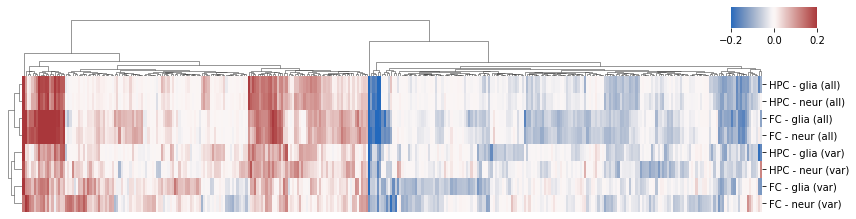

In [17]:
sns.clustermap(w_filt2.T, figsize=(12,3), dendrogram_ratio=[0.02,.3],
              cmap='vlag', method='complete',
               center=0, 
               vmin=-0.2, vmax=0.2,
               cbar_pos=(0.85, 0.9, 0.1, 0.1), 
                   cbar_kws=dict(orientation='horizontal'),
              xticklabels=False)
plt.show()

#### Figure 3B - hnRNP

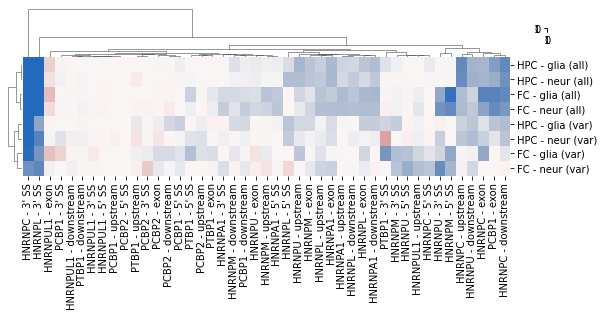

In [18]:
w_filt_genes = pd.DataFrame(w_filt.index)[0].str.split('_', n=1, expand=True)

hnrnp = ['HNRNPA1', 'HNRNPC', 'HNRNPL', 'HNRNPM', 'HNRNPU', 'HNRNPUL1',
       'PCBP1','PCBP2', 'PTBP1']

sns.clustermap(w_filt.iloc[np.isin(w_filt_genes[0], hnrnp)].T, figsize=(8.5,4.5), dendrogram_ratio=[0.03,.3],
              cmap='vlag', method='complete',
               center=0, 
               cbar_pos=(0.9, 0.9, 0.0, 0.), 
               vmin=-0.2, vmax=0.2, cbar=False,
              xticklabels=['HNRNPA1 - upstream', 'HNRNPC - upstream', 
                           'HNRNPL - upstream', 'HNRNPM - upstream',
                           'HNRNPU - upstream', 'HNRNPUL1 - upstream', 
                           'PCBP1 - upstream', 'PCBP2 - upstream',
                           'PTBP1 - upstream', "HNRNPA1 - 3' SS", 
                           "HNRNPC - 3' SS",
                           "HNRNPL - 3' SS", 
                           "HNRNPM - 3' SS", 
                           "HNRNPU - 3' SS",
                           "HNRNPUL1 - 3' SS", 
                           "PCBP1 - 3' SS", 
                           "PCBP2 - 3' SS",
                           "PTBP1 - 3' SS", 'HNRNPA1 - exon', 
                           'HNRNPC - exon', 'HNRNPL - exon',
                           'HNRNPM - exon', 'HNRNPU - exon', 
                           'HNRNPUL1 - exon', 'PCBP1 - exon',
                           'PCBP2 - exon', 'PTBP1 - exon', 'HNRNPA1 - downstream',
                           'HNRNPC - downstream', 'HNRNPL - downstream',
                           'HNRNPM - downstream', 'HNRNPU - downstream', 'HNRNPUL1 - downstream',
                           'PCBP1 - downstream', 'PCBP2 - downstream',
                           'PTBP1 - downstream', "HNRNPA1 - 5' SS", 
                           "HNRNPC - 5' SS",
                           "HNRNPL - 5' SS", "HNRNPM - 5' SS",
                           "HNRNPU - 5' SS", "HNRNPUL1 - 5' SS", 
                           "PCBP1 - 5' SS", "PCBP2 - 5' SS",
                           "PTBP1 - 5' SS"]
              )
plt.show()

#### Figure 3C - cell type specific RBPs

In [19]:
# Find top 10 with biggest different between neur and glia HPC var
ct_specific = np.abs(w_filt['HPC - neur (var)'] - w_filt['HPC - glia (var)']).sort_values(ascending=False)[:10].index
w_filt.loc[ct_specific]

,HPC - glia (all),HPC - neur (all),HPC - glia (var),HPC - neur (var),FC - glia (all),FC - neur (all),FC - glia (var),FC - neur (var)
QKI_start_overlap,-0.098697,-0.004609,-0.154732,0.121338,-0.113305,-0.023779,-0.131492,0.016850
MATR3_start_overlap,-0.156540,-0.024425,-0.190873,-0.000462,-0.004567,0.014810,-0.124401,0.038442
U2AF2_exon_complete,-0.003861,0.010134,-0.071185,0.069887,-0.014023,-0.002799,-0.048931,0.015483
PTBP1_start_overlap,-0.032418,0.001286,-0.048690,0.088437,-0.009825,0.013286,-0.134918,-0.004448
SSB_end_overlap,0.001870,0.007953,0.002986,0.112833,0.001728,0.006909,0.037338,0.125970
QKI_end,0.002426,-0.037638,-0.006597,-0.113609,-0.004749,-0.019235,-0.006189,-0.079459
ZNF622_exon_complete,0.000597,-0.000077,-0.006748,-0.113012,-0.015037,-0.007502,-0.060891,-0.000606
STAU2_start_overlap,-0.126207,-0.085894,-0.115437,-0.011643,-0.090427,-0.052951,0.001255,0.107955
IGF2BP1_end_overlap,0.162657,0.124775,0.166455,0.067298,0.214765,0.193007,0.070431,0.047166
EWSR1_start,0.058579,0.097100,0.021596,0.117653,0.059179,0.066041,0.000922,0.009098


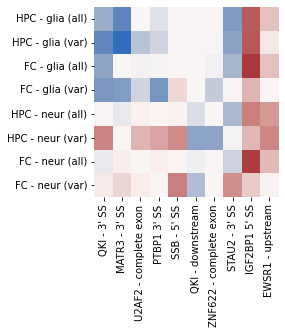

In [22]:
plt.figure(figsize=[3.3,3.5])
sns.heatmap(
    w_filt.loc[ct_specific].iloc[:,[0,2,4,6,1,3,5,7]].T, 
              cmap='vlag', 
               center=0, 
               vmin=-0.2, vmax=0.2, cbar=False,
              xticklabels=["QKI - 3' SS", "MATR3 - 3' SS", 
                           'U2AF2 - complete exon', "PTBP1 3' SS",
                           "SSB - 5' SS", 'QKI - downstream',
                           'ZNF622 - complete exon', "STAU2 - 3' SS", 
                           "IGF2BP1 5' SS", 'EWSR1 - upstream']
              )
plt.show()

#### Figure S13 - STAU2

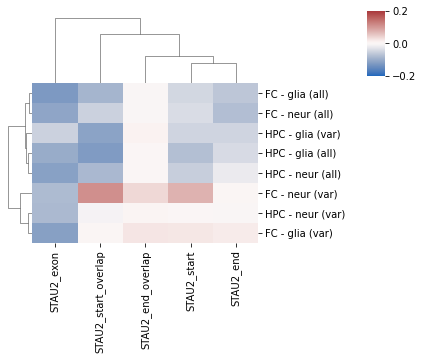

In [23]:
w_filt_genes = pd.DataFrame(w_filt.index)[0].str.split('_', n=1, expand=True)

sns.clustermap(w_filt[w_filt_genes[0].values == 'STAU2'].T, figsize=(5,5), dendrogram_ratio=[0.1,.3],
              cmap='vlag', method='complete',
               center=0, cbar_pos=(1.03, 0.8, 0.05, 0.18), vmin=-0.2, vmax=0.2,
              )
plt.show()

#### Figure S14 - HNRNPU

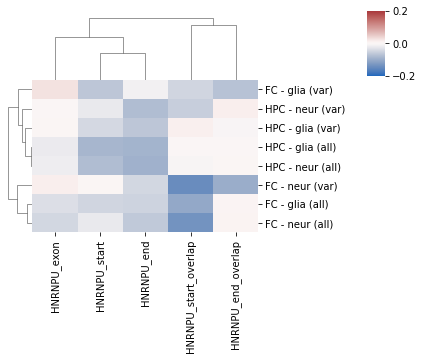

In [24]:
w_filt_genes = pd.DataFrame(w_filt.index)[0].str.split('_', n=1, expand=True)

sns.clustermap(w_filt[w_filt_genes[0].values == 'HNRNPU'].T, figsize=(5,5), dendrogram_ratio=[0.1,.3],
              cmap='vlag', method='complete',
               center=0, cbar_pos=(1.03, 0.8, 0.05, 0.18), vmin=-0.2, vmax=0.2,
              )
plt.show()